### 필수 library 설치
- PyTorch (1.5.1)
- torchaudio


In [ ]:
!pip install torch
!pip install torchaudio

     |████████████████████████████████| 6.7MB 2.6MB/s 


### Code (Tacotron2)

#### Reference 
- Tacotron2 (implemented by NVIDIA): https://github.com/NVIDIA/tacotron2
- 딥러닝 기반 음성인식 기초 (T-academy): https://tacademy.skplanet.com/live/player/onlineLectureDetail.action?seq=181

In [ ]:
import os
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader
import numpy as np
import unicodedata
import re
import time
from torch.autograd import Variable
from math import sqrt

print('Import 완료')

Import 완료


### 0. Hyperparameter 설정 및 device 확인
#### batch size는 큰 값을 갖는게 좋음

In [ ]:
class HParams():
    def __init__(self):
        self.n_mel_channels = 80

        ################################
        # Model Parameters             #
        ################################
        self.symbols_embedding_dim=512

        # Encoder parameters
        self.encoder_kernel_size=5
        self.encoder_n_convolutions=3
        self.encoder_embedding_dim=512

        # Decoder parameters
        self.n_frames_per_step=1  # currently only 1 is supported
        self.decoder_rnn_dim=1024
        self.prenet_dim=256
        self.max_decoder_steps=1000
        self.gate_threshold=0.5
        self.p_attention_dropout=0.1
        self.p_decoder_dropout=0.1

        # Attention parameters
        self.attention_rnn_dim=1024
        self.attention_dim=128

        # Location Layer parameters
        self.attention_location_n_filters=32
        self.attention_location_kernel_size=31

        # Mel-post processing network parameters
        self.postnet_embedding_dim=512
        self.postnet_kernel_size=5
        self.postnet_n_convolutions=5

        ################################
        # Optimization Hyperparameters #
        ################################
        self.use_saved_learning_rate=False
        self.learning_rate=1e-3
        self.weight_decay=1e-6
        self.grad_clip_thresh=1.0
        self.batch_size=4
        self.mask_padding=True  # set model's padded outputs to padded values
    
    
hparams = HParams()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  device = torch.device("cuda")
  print('GPU를 사용할 준비가 되었습니다.')
else:
  device = torch.device("cpu")
  print('CPU 모드입니다. GPU 설정으로 변경해주세요.')

GPU를 사용할 준비가 되었습니다.


### 1. Dataset (LJ Speech) 다운로드
#### Public data : LJ-Speech, VCTK, LibriTTS, (blizzard challenge data)


In [ ]:
LJSpeech_url = 'https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2'
train_dataset = torchaudio.datasets.LJSPEECH("", url=LJSpeech_url, download=True)

print('Download 완료')



Download 완료
Download 완료


### 2. Dataset 전처리
![Speech data processing](https://drive.google.com/file/d/11yPJ3PzhGtz6w3XZ8xdG-UQBNm1l3E_Z/view?usp=sharing)

In [ ]:
vocab = " abcdefghijklmnopqrstuvwxyz'.?"  # P: Padding, E: EOS.
char2idx = {char: idx for idx, char in enumerate(vocab)}
idx2char = {idx: char for idx, char in enumerate(vocab)}


def text_normalize(text):
    text = ''.join(char for char in unicodedata.normalize('NFD', text)
                   if unicodedata.category(char) != 'Mn')  # Strip accents

    text = text.lower()
    text = re.sub("[^{}]".format(vocab), " ", text)
    text = re.sub("[ ]+", " ", text)
    return text


class Collate():
  def __init__(self):
    self.wav_to_mel = torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_mels=80, win_length=1024, hop_length=256, f_min=0.0, f_max=8000.0, n_fft=1024)

  def __call__(self, batch):
    # batch: N_batch * [wav, sample_rate, text, text_normalized]
    mel_list = []
    for data in batch:
      wav = data[0]
      mel_list.append(self.wav_to_mel(wav).squeeze())
    input_lengths, ids_sorted_decreasing = torch.sort(torch.LongTensor([len(data[3]) for data in batch]), dim=0, descending=True)
    mel_lengths, ids_sorted_mel = torch.sort(torch.LongTensor([mel.shape[1] for mel in mel_list]), dim=0, descending=True)

    max_input_len = input_lengths[0]
    max_target_len = mel_lengths[0]

    text_padded = torch.LongTensor(len(batch), max_input_len)
    mel_padded = torch.FloatTensor(len(batch), 80, max_target_len)
    gate_padded = torch.FloatTensor(len(batch), max_target_len)
    output_lengths = torch.LongTensor(len(batch))

    text_padded.zero_()
    mel_padded.zero_()
    gate_padded.zero_()

    for i in range(len(ids_sorted_decreasing)):
        _, _, _, text = batch[ids_sorted_decreasing[i]]
        mel = mel_list[ids_sorted_decreasing[i]]
        mel = self.dynamic_range_compression(mel)
        mel_padded[i, :, :mel.size(1)] = mel
        gate_padded[i, mel.size(1)-1:] = 1
        output_lengths[i] = mel.size(1)
        text = text_normalize(text)
        text = [char2idx[char] for char in text]
        text_norm = torch.IntTensor(text)
        text_padded[i, :len(text)] = text_norm

    return text_padded, input_lengths, mel_padded, gate_padded, output_lengths

  def dynamic_range_compression(self, x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)

collate_fn = Collate()
train_loader = DataLoader(train_dataset, batch_size=hparams.batch_size, shuffle=True, drop_last=False, collate_fn=collate_fn)

print('Data 전처리 완료')

Data 전처리 완료


### 3. Tacotron2 모델 구현



#### 3-0) Basic model

In [ ]:
def get_mask_from_lengths(lengths):
    max_len = torch.max(lengths).item()
    ids = torch.arange(0, max_len, out=torch.cuda.LongTensor(max_len))
    mask = (ids < lengths.unsqueeze(1)).bool()
    return mask


def to_gpu(x):
    x = x.contiguous() #연산과정에서 메모리에 올려진 순서에 따라 발생할 수 있는 비효율성 혹은 최악의 경우 에러를 방지하기 위함
                        #예를들어 transpose의 경우 메모리에 올려진 순서가 연속성이 깨지게되는데 메모리 접근 성능이 비효율적으로됨

    if torch.cuda.is_available():
        x = x.cuda(non_blocking=True)
    return torch.autograd.Variable(x)


class LinearNorm(torch.nn.Module):
  def __init__(self, in_dim, out_dim, bias=True, w_init_gain='linear'):
      super(LinearNorm, self).__init__()
      self.linear_layer = torch.nn.Linear(in_dim, out_dim, bias=bias)

      torch.nn.init.xavier_uniform_(
          self.linear_layer.weight,
          gain=torch.nn.init.calculate_gain(w_init_gain))

  def forward(self, x):
      return self.linear_layer(x)


class ConvNorm(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                padding=None, dilation=1, bias=True, w_init_gain='linear'):
      super(ConvNorm, self).__init__()
      if padding is None:
          assert(kernel_size % 2 == 1)
          padding = int(dilation * (kernel_size - 1) / 2)

      self.conv = torch.nn.Conv1d(in_channels, out_channels,
                                  kernel_size=kernel_size, stride=stride,
                                  padding=padding, dilation=dilation,
                                  bias=bias)

      torch.nn.init.xavier_uniform_(
          self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))

  def forward(self, signal):
      conv_signal = self.conv(signal)
      return conv_signal


#### 3-1) Encoder
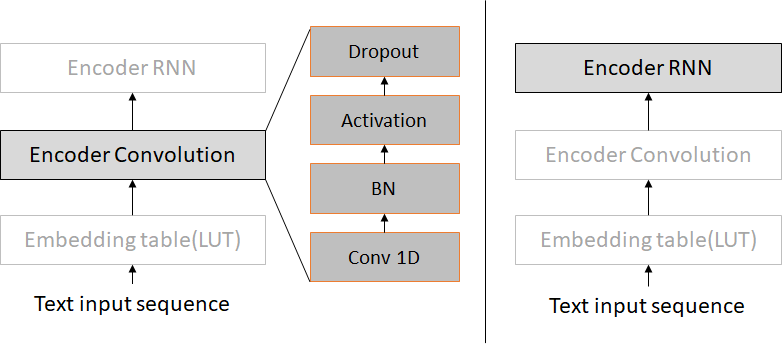

In [ ]:
class Encoder(nn.Module):
  """Encoder module:
      - Three 1-d convolution banks
      - Bidirectional LSTM
  """
  def __init__(self, hparams):
      super(Encoder, self).__init__()

      convolutions = []
      for _ in range(hparams.encoder_n_convolutions):
          conv_layer = nn.Sequential(
              ConvNorm(hparams.encoder_embedding_dim,
                        hparams.encoder_embedding_dim,
                        kernel_size=hparams.encoder_kernel_size, stride=1,
                        padding=int((hparams.encoder_kernel_size - 1) / 2),
                        dilation=1, w_init_gain='relu'),
              nn.BatchNorm1d(hparams.encoder_embedding_dim))
          convolutions.append(conv_layer)
      self.convolutions = nn.ModuleList(convolutions)

      self.lstm = nn.LSTM(hparams.encoder_embedding_dim,
                          int(hparams.encoder_embedding_dim / 2), 1,
                          batch_first=True, bidirectional=True)

  def forward(self, x, input_lengths):
      for conv in self.convolutions:
          x = F.dropout(F.relu(conv(x)), 0.5, self.training)

      x = x.transpose(1, 2)

      # pytorch tensor are not reversible, hence the conversion
      input_lengths = input_lengths.cpu().numpy()
      x = nn.utils.rnn.pack_padded_sequence(
          x, input_lengths, batch_first=True) #병렬 처리를 위해 padded된 sequence들을 packing하는 과정, 일종의 길이에 따른 sorting 과정 더 빠른 연산 가능

      self.lstm.flatten_parameters()
      outputs, _ = self.lstm(x)

      outputs, _ = nn.utils.rnn.pad_packed_sequence(
          outputs, batch_first=True)

      return outputs

  def inference(self, x):
      for conv in self.convolutions:
          x = F.dropout(F.relu(conv(x)), 0.5, self.training)

      x = x.transpose(1, 2)

      self.lstm.flatten_parameters()
      outputs, _ = self.lstm(x)

      return outputs

#### 3-2) Attention

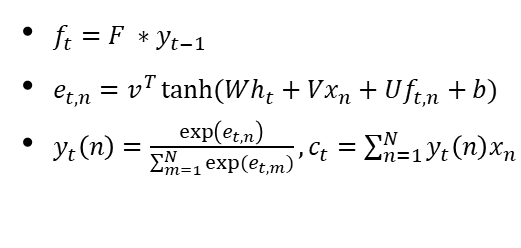

In [ ]:
class LocationLayer(nn.Module):
  def __init__(self, attention_n_filters, attention_kernel_size,
                attention_dim):
      super(LocationLayer, self).__init__()
      padding = int((attention_kernel_size - 1) / 2)
      self.location_conv = ConvNorm(2, attention_n_filters,
                                    kernel_size=attention_kernel_size,
                                    padding=padding, bias=False, stride=1,
                                    dilation=1)
      self.location_dense = LinearNorm(attention_n_filters, attention_dim,
                                        bias=False, w_init_gain='tanh')

  def forward(self, attention_weights_cat):
      processed_attention = self.location_conv(attention_weights_cat)
      processed_attention = processed_attention.transpose(1, 2)
      processed_attention = self.location_dense(processed_attention)
      return processed_attention


class Attention(nn.Module):
  def __init__(self, attention_rnn_dim, embedding_dim, attention_dim,
                attention_location_n_filters, attention_location_kernel_size):
      super(Attention, self).__init__()
      self.query_layer = LinearNorm(attention_rnn_dim, attention_dim,
                                    bias=False, w_init_gain='tanh')
      self.memory_layer = LinearNorm(embedding_dim, attention_dim, bias=False,
                                      w_init_gain='tanh')
      self.v = LinearNorm(attention_dim, 1, bias=False)
      self.location_layer = LocationLayer(attention_location_n_filters,
                                          attention_location_kernel_size,
                                          attention_dim)
      self.score_mask_value = -float("inf")

  def get_alignment_energies(self, query, processed_memory,
                              attention_weights_cat):
      """
      PARAMS
      ------
      query: decoder output (batch, n_mel_channels * n_frames_per_step)
      processed_memory: processed encoder outputs (B, T_in, attention_dim)
      attention_weights_cat: cumulative and prev. att weights (B, 2, max_time)

      RETURNS
      -------
      alignment (batch, max_time)
      """

      processed_query = self.query_layer(query.unsqueeze(1))
      processed_attention_weights = self.location_layer(attention_weights_cat)
      energies = self.v(torch.tanh(
          processed_query + processed_attention_weights + processed_memory))

      energies = energies.squeeze(-1)
      return energies

  def forward(self, attention_hidden_state, memory, processed_memory,
              attention_weights_cat, mask):
      """
      PARAMS
      ------
      attention_hidden_state: attention rnn last output
      memory: encoder outputs
      processed_memory: processed encoder outputs
      attention_weights_cat: previous and cummulative attention weights
      mask: binary mask for padded data
      """
      alignment = self.get_alignment_energies(
          attention_hidden_state, processed_memory, attention_weights_cat)

      if mask is not None:
          alignment.data.masked_fill_(mask, self.score_mask_value)

      attention_weights = F.softmax(alignment, dim=1)
      attention_context = torch.bmm(attention_weights.unsqueeze(1), memory) # bmm: batch matrix multiplication
      attention_context = attention_context.squeeze(1)

      return attention_context, attention_weights


#### 3-3) Decoder
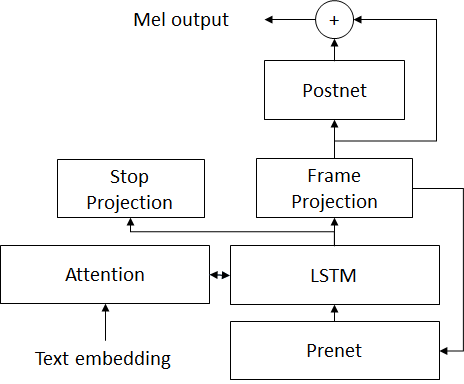

In [ ]:

class Prenet(nn.Module):
  def __init__(self, in_dim, sizes):
      super(Prenet, self).__init__()
      in_sizes = [in_dim] + sizes[:-1]
      self.layers = nn.ModuleList(
          [LinearNorm(in_size, out_size, bias=False)
            for (in_size, out_size) in zip(in_sizes, sizes)])

  def forward(self, x):
      for linear in self.layers:
          x = F.dropout(F.relu(linear(x)), p=0.5, training=True)
      return x


class Postnet(nn.Module):
  """Postnet
      - Five 1-d convolution with 512 channels and kernel size 5
  """

  def __init__(self, hparams):
      super(Postnet, self).__init__()
      self.convolutions = nn.ModuleList()

      self.convolutions.append(
          nn.Sequential(
              ConvNorm(hparams.n_mel_channels, hparams.postnet_embedding_dim,
                        kernel_size=hparams.postnet_kernel_size, stride=1,
                        padding=int((hparams.postnet_kernel_size - 1) / 2),
                        dilation=1, w_init_gain='tanh'),
              nn.BatchNorm1d(hparams.postnet_embedding_dim))
      )

      for i in range(1, hparams.postnet_n_convolutions - 1):
          self.convolutions.append(
              nn.Sequential(
                  ConvNorm(hparams.postnet_embedding_dim,
                            hparams.postnet_embedding_dim,
                            kernel_size=hparams.postnet_kernel_size, stride=1,
                            padding=int((hparams.postnet_kernel_size - 1) / 2),
                            dilation=1, w_init_gain='tanh'),
                  nn.BatchNorm1d(hparams.postnet_embedding_dim))
          )

      self.convolutions.append(
          nn.Sequential(
              ConvNorm(hparams.postnet_embedding_dim, hparams.n_mel_channels,
                        kernel_size=hparams.postnet_kernel_size, stride=1,
                        padding=int((hparams.postnet_kernel_size - 1) / 2),
                        dilation=1, w_init_gain='linear'),
              nn.BatchNorm1d(hparams.n_mel_channels))
          )

  def forward(self, x):
      for i in range(len(self.convolutions) - 1):
          x = F.dropout(torch.tanh(self.convolutions[i](x)), 0.5, self.training)
      x = F.dropout(self.convolutions[-1](x), 0.5, self.training)

      return x


class Decoder(nn.Module):
  def __init__(self, hparams):
      super(Decoder, self).__init__()
      self.n_mel_channels = hparams.n_mel_channels
      self.n_frames_per_step = hparams.n_frames_per_step
      self.encoder_embedding_dim = hparams.encoder_embedding_dim
      self.attention_rnn_dim = hparams.attention_rnn_dim
      self.decoder_rnn_dim = hparams.decoder_rnn_dim
      self.prenet_dim = hparams.prenet_dim
      self.max_decoder_steps = hparams.max_decoder_steps
      self.gate_threshold = hparams.gate_threshold
      self.p_attention_dropout = hparams.p_attention_dropout
      self.p_decoder_dropout = hparams.p_decoder_dropout

      self.prenet = Prenet(
          hparams.n_mel_channels * hparams.n_frames_per_step,
          [hparams.prenet_dim, hparams.prenet_dim])

      self.attention_rnn = nn.LSTMCell(
          hparams.prenet_dim + hparams.encoder_embedding_dim,
          hparams.attention_rnn_dim)

      self.attention_layer = Attention(
          hparams.attention_rnn_dim, hparams.encoder_embedding_dim,
          hparams.attention_dim, hparams.attention_location_n_filters,
          hparams.attention_location_kernel_size)

      self.decoder_rnn = nn.LSTMCell(
          hparams.attention_rnn_dim + hparams.encoder_embedding_dim,
          hparams.decoder_rnn_dim, 1)

      self.linear_projection = LinearNorm(
          hparams.decoder_rnn_dim + hparams.encoder_embedding_dim,
          hparams.n_mel_channels * hparams.n_frames_per_step)

      self.gate_layer = LinearNorm(
          hparams.decoder_rnn_dim + hparams.encoder_embedding_dim, 1,
          bias=True, w_init_gain='sigmoid')

  def get_go_frame(self, memory):
      """ Gets all zeros frames to use as first decoder input
      PARAMS
      ------
      memory: decoder outputs

      RETURNS
      -------
      decoder_input: all zeros frames
      """
      B = memory.size(0)
      decoder_input = Variable(memory.data.new(
          B, self.n_mel_channels * self.n_frames_per_step).zero_())
      return decoder_input

  def initialize_decoder_states(self, memory, mask):
      """ Initializes attention rnn states, decoder rnn states, attention
      weights, attention cumulative weights, attention context, stores memory
      and stores processed memory
      PARAMS
      ------
      memory: Encoder outputs
      mask: Mask for padded data if training, expects None for inference
      """
      B = memory.size(0)
      MAX_TIME = memory.size(1)

      self.attention_hidden = Variable(memory.data.new(
          B, self.attention_rnn_dim).zero_())
      self.attention_cell = Variable(memory.data.new(
          B, self.attention_rnn_dim).zero_())

      self.decoder_hidden = Variable(memory.data.new(
          B, self.decoder_rnn_dim).zero_())
      self.decoder_cell = Variable(memory.data.new(
          B, self.decoder_rnn_dim).zero_())

      self.attention_weights = Variable(memory.data.new(
          B, MAX_TIME).zero_())
      self.attention_weights_cum = Variable(memory.data.new(
          B, MAX_TIME).zero_())
      self.attention_context = Variable(memory.data.new(
          B, self.encoder_embedding_dim).zero_())

      self.memory = memory
      self.processed_memory = self.attention_layer.memory_layer(memory)
      self.mask = mask

  def parse_decoder_inputs(self, decoder_inputs):
      """ Prepares decoder inputs, i.e. mel outputs
      PARAMS
      ------
      decoder_inputs: inputs used for teacher-forced training, i.e. mel-specs

      RETURNS
      -------
      inputs: processed decoder inputs

      """
      # (B, n_mel_channels, T_out) -> (B, T_out, n_mel_channels)
      decoder_inputs = decoder_inputs.transpose(1, 2)
      decoder_inputs = decoder_inputs.view(
          decoder_inputs.size(0),
          int(decoder_inputs.size(1)/self.n_frames_per_step), -1)
      # (B, T_out, n_mel_channels) -> (T_out, B, n_mel_channels)
      decoder_inputs = decoder_inputs.transpose(0, 1)
      return decoder_inputs

  def parse_decoder_outputs(self, mel_outputs, gate_outputs, alignments):
      """ Prepares decoder outputs for output
      PARAMS
      ------
      mel_outputs:
      gate_outputs: gate output energies
      alignments:

      RETURNS
      -------
      mel_outputs:
      gate_outpust: gate output energies
      alignments:
      """
      # (T_out, B) -> (B, T_out)
      alignments = torch.stack(alignments).transpose(0, 1)
      # (T_out, B) -> (B, T_out)
      gate_outputs = torch.stack(gate_outputs).transpose(0, 1)
      gate_outputs = gate_outputs.contiguous()
      # (T_out, B, n_mel_channels) -> (B, T_out, n_mel_channels)
      mel_outputs = torch.stack(mel_outputs).transpose(0, 1).contiguous()
      # decouple frames per step
      mel_outputs = mel_outputs.view(
          mel_outputs.size(0), -1, self.n_mel_channels)
      # (B, T_out, n_mel_channels) -> (B, n_mel_channels, T_out)
      mel_outputs = mel_outputs.transpose(1, 2)

      return mel_outputs, gate_outputs, alignments

  def decode(self, decoder_input):
      """ Decoder step using stored states, attention and memory
      PARAMS
      ------
      decoder_input: previous mel output

      RETURNS
      -------
      mel_output:
      gate_output: gate output energies
      attention_weights:
      """
      cell_input = torch.cat((decoder_input, self.attention_context), -1)
      self.attention_hidden, self.attention_cell = self.attention_rnn(
          cell_input, (self.attention_hidden, self.attention_cell))
      self.attention_hidden = F.dropout(
          self.attention_hidden, self.p_attention_dropout, self.training)

      attention_weights_cat = torch.cat(
          (self.attention_weights.unsqueeze(1),
            self.attention_weights_cum.unsqueeze(1)), dim=1)
      self.attention_context, self.attention_weights = self.attention_layer(
          self.attention_hidden, self.memory, self.processed_memory,
          attention_weights_cat, self.mask) 

      self.attention_weights_cum += self.attention_weights
      decoder_input = torch.cat(
          (self.attention_hidden, self.attention_context), -1)
      self.decoder_hidden, self.decoder_cell = self.decoder_rnn(
          decoder_input, (self.decoder_hidden, self.decoder_cell))
      self.decoder_hidden = F.dropout(
          self.decoder_hidden, self.p_decoder_dropout, self.training)

      decoder_hidden_attention_context = torch.cat(
          (self.decoder_hidden, self.attention_context), dim=1)
      decoder_output = self.linear_projection(
          decoder_hidden_attention_context)

      gate_prediction = self.gate_layer(decoder_hidden_attention_context)
      return decoder_output, gate_prediction, self.attention_weights

  def forward(self, memory, decoder_inputs, memory_lengths):
      """ Decoder forward pass for training
      PARAMS
      ------
      memory: Encoder outputs
      decoder_inputs: Decoder inputs for teacher forcing. i.e. mel-specs
      memory_lengths: Encoder output lengths for attention masking.

      RETURNS
      -------
      mel_outputs: mel outputs from the decoder
      gate_outputs: gate outputs from the decoder
      alignments: sequence of attention weights from the decoder
      """

      decoder_input = self.get_go_frame(memory).unsqueeze(0)
      decoder_inputs = self.parse_decoder_inputs(decoder_inputs)
      decoder_inputs = torch.cat((decoder_input, decoder_inputs), dim=0)
      decoder_inputs = self.prenet(decoder_inputs)

      self.initialize_decoder_states(
          memory, mask=~get_mask_from_lengths(memory_lengths))

      mel_outputs, gate_outputs, alignments = [], [], []
      while len(mel_outputs) < decoder_inputs.size(0) - 1:
          decoder_input = decoder_inputs[len(mel_outputs)]
          mel_output, gate_output, attention_weights = self.decode(
              decoder_input)
          mel_outputs += [mel_output.squeeze(1)]
          gate_outputs += [gate_output.squeeze(1)]
          alignments += [attention_weights]

      mel_outputs, gate_outputs, alignments = self.parse_decoder_outputs(
          mel_outputs, gate_outputs, alignments)

      return mel_outputs, gate_outputs, alignments

  def inference(self, memory):
      """ Decoder inference
      PARAMS
      ------
      memory: Encoder outputs

      RETURNS
      -------
      mel_outputs: mel outputs from the decoder
      gate_outputs: gate outputs from the decoder
      alignments: sequence of attention weights from the decoder
      """
      decoder_input = self.get_go_frame(memory)

      self.initialize_decoder_states(memory, mask=None)

      mel_outputs, gate_outputs, alignments = [], [], []
      while True: #free learning 모드
          decoder_input = self.prenet(decoder_input)
          mel_output, gate_output, alignment = self.decode(decoder_input)

          mel_outputs += [mel_output.squeeze(1)]
          gate_outputs += [gate_output]
          alignments += [alignment]

          if torch.sigmoid(gate_output.data) > self.gate_threshold:
              break
          elif len(mel_outputs) == self.max_decoder_steps:
              print("Warning! Reached max decoder steps")
              break

          decoder_input = mel_output

      mel_outputs, gate_outputs, alignments = self.parse_decoder_outputs(
          mel_outputs, gate_outputs, alignments)

      return mel_outputs, gate_outputs, alignments


#### 3-4) Tacotron2

In [ ]:
class Tacotron2(nn.Module):
  def __init__(self, hparams):
      super(Tacotron2, self).__init__()
      self.mask_padding = hparams.mask_padding
      self.n_mel_channels = hparams.n_mel_channels
      self.n_frames_per_step = hparams.n_frames_per_step
      self.embedding = nn.Embedding(
          len(vocab), hparams.symbols_embedding_dim)
      std = sqrt(2.0 / (len(vocab) + hparams.symbols_embedding_dim))
      val = sqrt(3.0) * std  # uniform bounds for std
      self.embedding.weight.data.uniform_(-val, val)
      self.encoder = Encoder(hparams)
      self.decoder = Decoder(hparams)
      self.postnet = Postnet(hparams)

  def parse_batch(self, batch):
      text_padded, input_lengths, mel_padded, gate_padded, \
          output_lengths = batch
      text_padded = to_gpu(text_padded).long()
      input_lengths = to_gpu(input_lengths).long()
      max_len = torch.max(input_lengths.data).item()
      mel_padded = to_gpu(mel_padded).float()
      gate_padded = to_gpu(gate_padded).float()
      output_lengths = to_gpu(output_lengths).long()

      return (
          (text_padded, input_lengths, mel_padded, max_len, output_lengths),
          (mel_padded, gate_padded))

  def parse_output(self, outputs, output_lengths=None):
      if self.mask_padding and output_lengths is not None:
          mask = ~get_mask_from_lengths(output_lengths)
          mask = mask.expand(self.n_mel_channels, mask.size(0), mask.size(1))
          mask = mask.permute(1, 0, 2)

          outputs[0].data.masked_fill_(mask, 0.0)
          outputs[1].data.masked_fill_(mask, 0.0)
          outputs[2].data.masked_fill_(mask[:, 0, :], 1e3)  # gate energies

      return outputs

  def forward(self, inputs):
      text_inputs, text_lengths, mels, max_len, output_lengths = inputs
      text_lengths, output_lengths = text_lengths.data, output_lengths.data

      embedded_inputs = self.embedding(text_inputs).transpose(1, 2) #LUT

      encoder_outputs = self.encoder(embedded_inputs, text_lengths)

      mel_outputs, gate_outputs, alignments = self.decoder(
          encoder_outputs, mels, memory_lengths=text_lengths)

      mel_outputs_postnet = self.postnet(mel_outputs)
      mel_outputs_postnet = mel_outputs + mel_outputs_postnet

      return self.parse_output(
          [mel_outputs, mel_outputs_postnet, gate_outputs, alignments],
          output_lengths)

  def inference(self, inputs):
      embedded_inputs = self.embedding(inputs).transpose(1, 2)
      encoder_outputs = self.encoder.inference(embedded_inputs)
      mel_outputs, gate_outputs, alignments = self.decoder.inference(
          encoder_outputs)

      mel_outputs_postnet = self.postnet(mel_outputs)
      mel_outputs_postnet = mel_outputs + mel_ouftputs_postnet

      outputs = self.parse_output(
          [mel_outputs, mel_outputs_postnet, gate_outputs, alignments])

      return outputs

### 4. 모델 선언 및 옵티마이저 설정

In [ ]:
model = Tacotron2(hparams).to(device)
learning_rate = hparams.learning_rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                              weight_decay=hparams.weight_decay)

### 5. 목적 함수 정의

In [ ]:
class Tacotron2Loss(nn.Module):
  def __init__(self):
      super(Tacotron2Loss, self).__init__()

  def forward(self, model_output, targets):
      mel_target, gate_target = targets[0], targets[1]
      mel_target.requires_grad = False
      gate_target.requires_grad = False
      gate_target = gate_target.view(-1, 1)

      mel_out, mel_out_postnet, gate_out, _ = model_output
      gate_out = gate_out.view(-1, 1)
      mel_loss = nn.MSELoss()(mel_out, mel_target) + nn.MSELoss()(mel_out_postnet, mel_target)
      gate_loss = nn.BCEWithLogitsLoss()(gate_out, gate_target) #binary cross entropy (BCE보다 안정적)
      return mel_loss + gate_loss

criterion = Tacotron2Loss()

### 6. 훈련

In [ ]:
iteration = 0

for epoch in range(100):
  print("Epoch: {}".format(epoch))
  for i, batch in enumerate(train_loader):
    start = time.perf_counter()
    model.zero_grad()
    x, y = model.parse_batch(batch)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    reduced_loss = loss.item()  #[1.0] -> 1.0
    loss.backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(
        model.parameters(), hparams.grad_clip_thresh)

    optimizer.step()

    duration = time.perf_counter() - start
    print("Train loss {} {:.6f} Grad Norm {:.6f} {:.2f}s/it".format(
        iteration, reduced_loss, grad_norm, duration))
    
    iteration += 1

Epoch: 0
